## Galaxy_viewer

Produces an image of a single galaxy or several

In [18]:
import numpy as np
import matplotlib
import pandas as pd
# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt

import lsst.daf.butler as dafButler     # gen3 butler
from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query    

import lsst.sphgeom
import lsst.afw.display as afwDisplay
import lsst.geom
from lsst.geom import SpherePoint, Angle
afwDisplay.setDefaultBackend('matplotlib') 

repo = 's3://butler-us-central1-dp01'  

# Get an instance of the TAP service
service = lsst.rsp.get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

dataset='DC2'
#genvers='gen2'
genvers='gen3'

# Access DC2 gen3 repository
#repo='/repo/dc2'
#collection='2.2i/runs/DP0.1'
#repo='s3://butler-us-central1-dp01'
collection=['2.2i/runs/DP0.1/calexp/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy',
                    'skymaps']

# Open the butler for this gen3 repo...
butler = dafButler.Butler(repo,collections=collection)

In [19]:
data = pd.read_csv('input.txt', delim_whitespace=True)

ii=0
filter_id='r'

ra1 = data['ra']
dec1 = data['dec']

ra = ra1.iloc[ii]
dec = dec1.iloc[ii]

In [20]:
#my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
print(my_spherePoint)

#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
tract1 = str(my_tract)
patch1_ok = str(my_patch_id)
tract1_ok = tract1[13:17]
tract = int(tract1_ok)
patch = int(patch1_ok)

#dataId = """{'band': """+"""'"""+filter_id+"""','tract': """+tract1_ok+""", 'patch':"""+tract2+"""}"""

dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}

print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ',my_patch_id)
print(dataId)

(62.0291800000, -36.7025080000)
my_tract =  TractInfo(id=3831)
my_patch =  PatchInfo(index=Index2D(x=3, y=2))
my_patch_id =  17
{'band': 'r', 'tract': 3831, 'patch': 17}


dict_keys(['band', 'skymap', 'tract', 'patch'])
{'band': 'r', 'tract': 3831, 'patch': 17}


In [22]:
coadd_type = 'deepCoadd'

if genvers == 'gen2':
    butler.getKeys(coadd_type)
elif genvers == 'gen3':
    print(butler.registry.getDatasetType(coadd_type).dimensions.required.names)

# Retrieve the image using butler
if genvers == 'gen2':
    coadd_id = {'tract': tract, 'patch': patch, 'filter': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)
elif genvers == 'gen3':
    coadd_id = {'tract': tract, 'patch': patch, 'band': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)

print(tract)
print(patch)
print(filter_id)
print(dataId)

r
3831
17
r
{'band': 'r', 'tract': 3831, 'patch': 17}


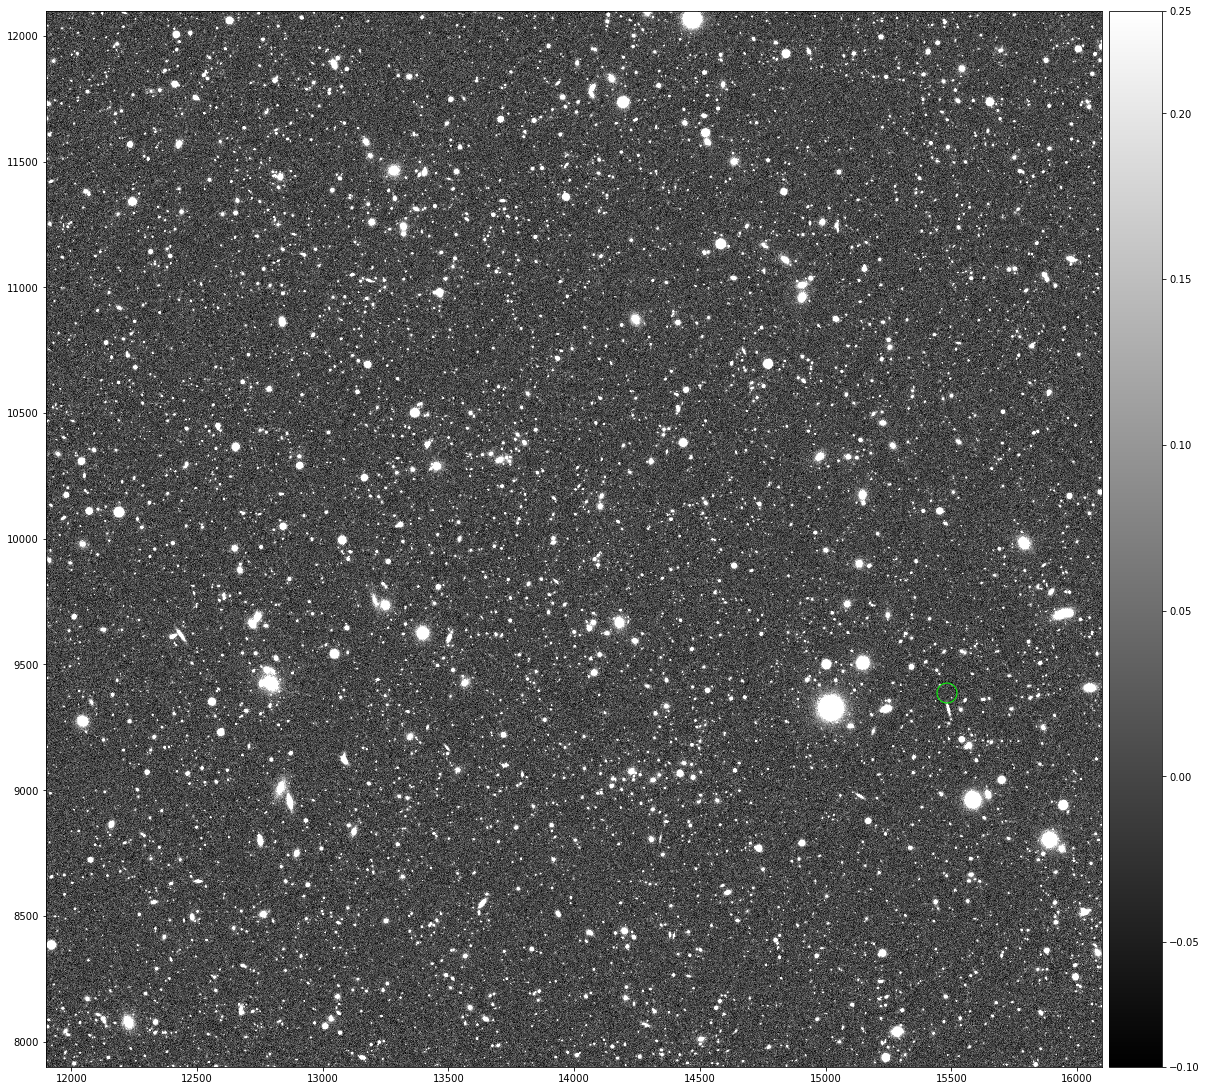

In [23]:
# Let's take a look at the full image first
radec = SpherePoint(ra, dec, lsst.geom.degrees)
xy = image.getWcs().skyToPixel(radec)

fig = plt.figure(figsize=(20,20))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(image.getMaskedImage().getImage())
display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)

(62.0290600000, -36.7025080000)


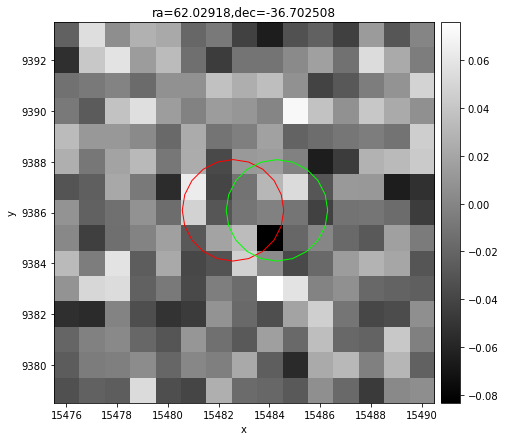

In [16]:
fig, ax = plt.subplots(5, 4, figsize=(14, 7))
# Define the center and size of our cutout
radec = SpherePoint(ra, dec, lsst.geom.degrees)
cutout_size = 15
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

ra2 = ra-0.00012
dec2 = dec-0.00000
radec2 = SpherePoint(ra2, dec2, lsst.geom.degrees)
xy2 = image.getWcs().skyToPixel(radec2)
print(radec2)

# Cutout and optionally save the postage stamp to file
postage_stamp = image.getCutout(radec, cutout_extent)
# postage_stamp.writeFits(<output_filename>)

# Convert RA,DEC on the sky to X,Y in the image
xy = postage_stamp.getWcs().skyToPixel(radec)

# Display image
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.mtv(postage_stamp.getImage())
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red', size=2)
display.dot('o', xy2.getX(), xy2.getY(), ctype='green', size=2)
display.show_colorbar()

plt.xlabel('x')
plt.ylabel('y')
plt.title('ra='+str(ra)+','+'dec='+str(dec))#+','+'mag_r='+str(mag_r))
plt.show()
